<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [ ]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

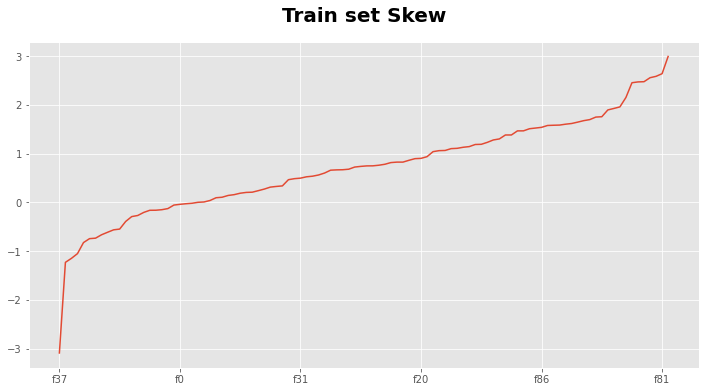

In [ ]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

In [ ]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

# Clustering 적용하자

In [3]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 44 kB/s 
     |████████████████████████████████| 302 kB 8.4 MB/s 
     |████████████████████████████████| 164 kB 65.0 MB/s 
     |████████████████████████████████| 80 kB 11.5 MB/s 
     |████████████████████████████████| 75 kB 6.1 MB/s 
     |████████████████████████████████| 111 kB 77.9 MB/s 
     |████████████████████████████████| 141 kB 67.0 MB/s 
     |████████████████████████████████| 49 kB 8.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=7b641cbc564f79a17016a10f23287d14741411de0b51259d0656641496f427c8
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import catboost
import optuna
import optuna.integration.lightgbm as lgbo
import lightgbm
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

In [6]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

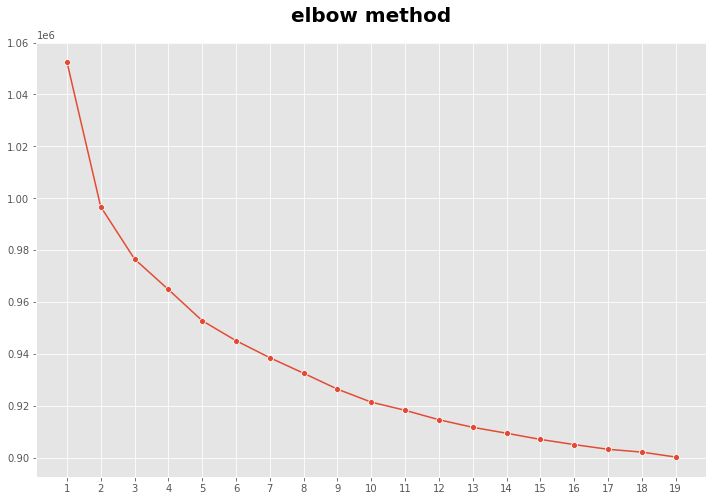

In [ ]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.1039045	test: 1.1063753	best: 1.1063753 (0)	total: 10.3ms	remaining: 30.9s
100:	learn: 1.0945647	test: 1.0977858	best: 1.0977858 (100)	total: 1.8s	remaining: 51.6s
200:	learn: 1.0901819	test: 1.0942911	best: 1.0942911 (200)	total: 2.91s	remaining: 40.6s
300:	learn: 1.0869794	test: 1.0920953	best: 1.0920953 (300)	total: 4.21s	remaining: 37.7s
400:	learn: 1.0843921	test: 1.0905177	best: 1.0905177 (400)	total: 5.58s	remaining: 36.2s
500:	learn: 1.0821666	test: 1.0893155	best: 1.0893155 (500)	total: 7.41s	remaining: 37s
600:	learn: 1.0800835	test: 1.0882926	best: 1.0882926 (600)	total: 9.82s	remaining: 39.2s
700:	learn: 1.0781490	test: 1.0874149	best: 1.0874149 (700)	total: 12.1s	remaining: 39.7s
800:	learn: 1.0763697	test: 1.0866818	best: 1.0866818 (800)	total: 14.4s	remaining: 39.6s
900:	learn: 1.0746677	test: 1.0860741	best: 1.0860741 (900)	total: 16.9s	remaining: 39.3s
1000:	learn: 1.0730308	test: 1.0855342	best: 1.0855342 (1000)	total: 18.9s	remaining: 37.8s
1100:	learn: 1

# LGBM LB: 7.90478

In [25]:
params = {'objective':'poisson', 'metric': 'rmse'} #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
lgb_train = lightgbm.Dataset(X_train, Y_train)
lgb_valid = lightgbm.Dataset(X_test, Y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

[I 2021-08-25 05:12:16,843] A new study created in memory with name: no-name-777017c5-0e8f-4524-9b9f-907a3fbb7e19

feature_fraction, val_score: 7.878592:  14%|#4        | 1/7 [00:11<01:08, 11.35s/it][I 2021-08-25 05:12:28,214] Trial 0 finished with value: 7.878591863643372 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 7.878591863643372.

feature_fraction, val_score: 7.878592:  29%|##8       | 2/7 [00:27<01:11, 14.36s/it][I 2021-08-25 05:12:44,682] Trial 1 finished with value: 7.87925420394927 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 7.878591863643372.

feature_fraction, val_score: 7.878592:  43%|####2     | 3/7 [00:41<00:55, 13.92s/it][I 2021-08-25 05:12:58,082] Trial 2 finished with value: 7.878997030894204 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 7.878591863643372.

feature_fraction, val_score: 7.878592:  57%|#####7    | 4/7 [00:51<00:37, 12.52s/it][I 2021-08-25 05:13:08,465] Trial 3 finished with va

{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.5,
 'feature_pre_filter': False,
 'lambda_l1': 1.3849563081956646e-08,
 'lambda_l2': 4.9770465844969305,
 'metric': 'rmse',
 'min_child_samples': 20,
 'num_leaves': 82,
 'objective': 'poisson'}

In [27]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
best_lgb_params = model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["num_iterations"] = 10000

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgb = lightgbm.LGBMRegressor(**best_lgb_params)
  model_lgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  preds += model_lgb.predict(x_test) / kf.n_splits
  val_preds = model_lgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.92009	valid_1's rmse: 7.90742
[200]	training's rmse: 7.89726	valid_1's rmse: 7.89777
[300]	training's rmse: 7.87613	valid_1's rmse: 7.88995
[400]	training's rmse: 7.85645	valid_1's rmse: 7.88361
[500]	training's rmse: 7.83748	valid_1's rmse: 7.87815
[600]	training's rmse: 7.8191	valid_1's rmse: 7.87327
[700]	training's rmse: 7.80133	valid_1's rmse: 7.86881
[800]	training's rmse: 7.784	valid_1's rmse: 7.8649
[900]	training's rmse: 7.76684	valid_1's rmse: 7.86117
[1000]	training's rmse: 7.75	valid_1's rmse: 7.85778
[1100]	training's rmse: 7.73343	valid_1's rmse: 7.85467
[1200]	training's rmse: 7.71723	valid_1's rmse: 7.85208
[1300]	training's rmse: 7.70121	valid_1's rmse: 7.84958
[1400]	training's rmse: 7.68536	valid_1's rmse: 7.84719
[1500]	training's rmse: 7.66968	valid_1's rmse: 7.84508
[1600]	training's rmse: 7.65414	valid_1's rmse: 7.84317
[1700]	training's rmse: 7.63894	valid_1's rmse: 7.84136
[1

# XGBoost LB: 

In [13]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 12), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'tree_method' : 'gpu_hist',
        'booster' : 'gbtree',
        'loss_function':'rmse',
        'eval_metric':'rmse'
     }

    model = xgboost.XGBRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [14]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-25 03:54:43,829] A new study created in memory with name: no-name-2227ea98-adf0-4fc0-a322-ca8a1ebb1973


[03:54:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:54:49,485] Trial 0 finished with value: 7.826648414231014 and parameters: {'max_depth': 6, 'n_estimators': 2800, 'eta': 0.01274308068993322, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.9, 'min_child_weight': 1070.2664974067193, 'reg_lambda': 0.0036458090805978616, 'reg_alpha': 444.60978976375463, 'gamma': 0.00013697888181286213}. Best is trial 0 with value: 7.826648414231014.


[03:54:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:54:57,314] Trial 1 finished with value: 7.821610701851589 and parameters: {'max_depth': 6, 'n_estimators': 800, 'eta': 0.009990096724079321, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'min_child_weight': 0.026545938570533698, 'reg_lambda': 0.00032404566015960403, 'reg_alpha': 1262.7419429561483, 'gamma': 5.583811610330947}. Best is trial 1 with value: 7.821610701851589.


[03:54:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:01,211] Trial 2 finished with value: 7.920963784359042 and parameters: {'max_depth': 9, 'n_estimators': 2000, 'eta': 0.009170690298042902, 'subsample': 0.2, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.2, 'min_child_weight': 0.007125974239649181, 'reg_lambda': 0.28651987714095245, 'reg_alpha': 0.0017430781639255653, 'gamma': 2179.994864561317}. Best is trial 1 with value: 7.821610701851589.


[03:55:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:05,259] Trial 3 finished with value: 7.852721441701072 and parameters: {'max_depth': 7, 'n_estimators': 4000, 'eta': 0.009136900223216072, 'subsample': 0.8, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 0.08045567368062305, 'reg_lambda': 0.11017719801774957, 'reg_alpha': 2.5228234796710547, 'gamma': 138.1125572886089}. Best is trial 1 with value: 7.821610701851589.


[03:55:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:16,455] Trial 4 finished with value: 7.832100868498096 and parameters: {'max_depth': 11, 'n_estimators': 1600, 'eta': 0.012202210588992162, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.9, 'min_child_weight': 49.56741806229761, 'reg_lambda': 1089.6100692572027, 'reg_alpha': 13.349821730929516, 'gamma': 0.0001341239245783912}. Best is trial 1 with value: 7.821610701851589.


[03:55:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:20,262] Trial 5 finished with value: 7.838694608295846 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.011220214624010495, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5, 'min_child_weight': 184.59974839177076, 'reg_lambda': 0.2566164237313176, 'reg_alpha': 0.015129057735245881, 'gamma': 0.001096387031083617}. Best is trial 1 with value: 7.821610701851589.


[03:55:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:30,105] Trial 6 finished with value: 7.884822172634137 and parameters: {'max_depth': 11, 'n_estimators': 1600, 'eta': 0.01256945234191234, 'subsample': 0.7, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.001002814406656778, 'reg_lambda': 0.6482259263732018, 'reg_alpha': 1.6695901603914867, 'gamma': 5812.224871392973}. Best is trial 1 with value: 7.821610701851589.


[03:55:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:39,438] Trial 7 finished with value: 7.8808641882583785 and parameters: {'max_depth': 5, 'n_estimators': 2800, 'eta': 0.010230453101330065, 'subsample': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 0.6231804610837132, 'reg_lambda': 25.91303315164021, 'reg_alpha': 9257.715361033743, 'gamma': 101.93621292147196}. Best is trial 1 with value: 7.821610701851589.


[03:55:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:42,289] Trial 8 finished with value: 7.868638596212403 and parameters: {'max_depth': 7, 'n_estimators': 800, 'eta': 0.007618012057750171, 'subsample': 0.2, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.2, 'min_child_weight': 142.4605103384454, 'reg_lambda': 0.00022771459755974825, 'reg_alpha': 1.935147205634747, 'gamma': 0.0035047156614219912}. Best is trial 1 with value: 7.821610701851589.


[03:55:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:52,273] Trial 9 finished with value: 7.833713177965325 and parameters: {'max_depth': 8, 'n_estimators': 3600, 'eta': 0.012745463145632635, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 670.0893425466254, 'reg_lambda': 0.0001606864736772558, 'reg_alpha': 2497.409201823306, 'gamma': 7115.289287420889}. Best is trial 1 with value: 7.821610701851589.


[03:55:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:55:57,675] Trial 10 finished with value: 7.823998986179459 and parameters: {'max_depth': 4, 'n_estimators': 800, 'eta': 0.007070647992979162, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 3.944839208940022, 'reg_lambda': 0.0056962154406639785, 'reg_alpha': 46.2540083566687, 'gamma': 0.15202152169215327}. Best is trial 1 with value: 7.821610701851589.


[03:55:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:01,759] Trial 11 finished with value: 7.824573708606075 and parameters: {'max_depth': 4, 'n_estimators': 400, 'eta': 0.00701586281585711, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 1.8529763566376198, 'reg_lambda': 0.0025410727171334174, 'reg_alpha': 89.33898184504658, 'gamma': 0.24860448210757627}. Best is trial 1 with value: 7.821610701851589.


[03:56:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:06,537] Trial 12 finished with value: 7.835883383044794 and parameters: {'max_depth': 4, 'n_estimators': 800, 'eta': 0.00830882237934417, 'subsample': 0.4, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 0.00014614461708612912, 'reg_lambda': 0.011006326446345742, 'reg_alpha': 89.41248839824335, 'gamma': 0.4076883889545273}. Best is trial 1 with value: 7.821610701851589.


[03:56:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:11,284] Trial 13 finished with value: 7.830056840496672 and parameters: {'max_depth': 5, 'n_estimators': 1200, 'eta': 0.010484725690864578, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'min_child_weight': 6.805182797286592, 'reg_lambda': 14.154856400917174, 'reg_alpha': 0.04305073067233514, 'gamma': 7.191072939124597}. Best is trial 1 with value: 7.821610701851589.


[03:56:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:15,400] Trial 14 finished with value: 7.826870320785744 and parameters: {'max_depth': 4, 'n_estimators': 400, 'eta': 0.009025524618611086, 'subsample': 0.7, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'min_child_weight': 0.05975093338244714, 'reg_lambda': 0.014211133026803073, 'reg_alpha': 724.5263719135964, 'gamma': 0.033509328696809344}. Best is trial 1 with value: 7.821610701851589.


[03:56:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:22,916] Trial 15 finished with value: 7.844374876145428 and parameters: {'max_depth': 6, 'n_estimators': 1200, 'eta': 0.011322916157082356, 'subsample': 0.4, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 9945.890932397784, 'reg_lambda': 0.0005801771778112393, 'reg_alpha': 47.34210630704067, 'gamma': 4.437671506963956}. Best is trial 1 with value: 7.821610701851589.


[03:56:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:30,616] Trial 16 finished with value: 7.8279826932065095 and parameters: {'max_depth': 9, 'n_estimators': 2400, 'eta': 0.008101340499506312, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'min_child_weight': 0.0672828036057603, 'reg_lambda': 0.034526196995021005, 'reg_alpha': 1174.8325163499546, 'gamma': 0.03493415602371603}. Best is trial 1 with value: 7.821610701851589.


[03:56:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:34,173] Trial 17 finished with value: 7.835672891367934 and parameters: {'max_depth': 5, 'n_estimators': 800, 'eta': 0.009619996236860452, 'subsample': 0.5, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.5, 'min_child_weight': 0.006257337515692196, 'reg_lambda': 6.5906837276441905, 'reg_alpha': 0.17330059610207044, 'gamma': 25.02040258427793}. Best is trial 1 with value: 7.821610701851589.


[03:56:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:38,550] Trial 18 finished with value: 7.850702383916324 and parameters: {'max_depth': 7, 'n_estimators': 1600, 'eta': 0.007037697288395791, 'subsample': 0.7, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'min_child_weight': 10.536440679144082, 'reg_lambda': 0.0013322809722364013, 'reg_alpha': 14.526796329230946, 'gamma': 0.08129672524536445}. Best is trial 1 with value: 7.821610701851589.


[03:56:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:42,375] Trial 19 finished with value: 7.871966174022587 and parameters: {'max_depth': 9, 'n_estimators': 400, 'eta': 0.011036503241959858, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'min_child_weight': 0.37001372986352454, 'reg_lambda': 585.012124600823, 'reg_alpha': 6702.724308933252, 'gamma': 1.8652978123315127}. Best is trial 1 with value: 7.821610701851589.


[03:56:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:45,924] Trial 20 finished with value: 7.837148690963469 and parameters: {'max_depth': 5, 'n_estimators': 1200, 'eta': 0.011857342077217586, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 0.008649613209398171, 'reg_lambda': 0.00013822484235168932, 'reg_alpha': 0.00011556211529200473, 'gamma': 430.99736598507917}. Best is trial 1 with value: 7.821610701851589.


[03:56:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:50,015] Trial 21 finished with value: 7.82369085902229 and parameters: {'max_depth': 4, 'n_estimators': 400, 'eta': 0.007155186531186115, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'min_child_weight': 5.125141787525483, 'reg_lambda': 0.00362040230683647, 'reg_alpha': 236.7201596084082, 'gamma': 0.3342539321258287}. Best is trial 1 with value: 7.821610701851589.


[03:56:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:56:56,067] Trial 22 finished with value: 7.8226551162459055 and parameters: {'max_depth': 4, 'n_estimators': 800, 'eta': 0.007964785882600744, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 6.256383104180212, 'reg_lambda': 0.005413459582505208, 'reg_alpha': 330.37682343171286, 'gamma': 0.8969299563540102}. Best is trial 1 with value: 7.821610701851589.


[03:56:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:57:00,668] Trial 23 finished with value: 7.822593927172129 and parameters: {'max_depth': 5, 'n_estimators': 400, 'eta': 0.00809085697762329, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 24.37664633737023, 'reg_lambda': 0.05152301898921503, 'reg_alpha': 311.32954915721245, 'gamma': 1.0084767069140104}. Best is trial 1 with value: 7.821610701851589.


[03:57:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:57:14,209] Trial 24 finished with value: 7.8237920273973165 and parameters: {'max_depth': 6, 'n_estimators': 1200, 'eta': 0.008423155393283567, 'subsample': 0.7, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 28.19719650080556, 'reg_lambda': 0.0659286773238935, 'reg_alpha': 2020.0797532771658, 'gamma': 8.420982178945861}. Best is trial 1 with value: 7.821610701851589.


[03:57:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:57:19,228] Trial 25 finished with value: 7.8255297631665295 and parameters: {'max_depth': 5, 'n_estimators': 2000, 'eta': 0.007786995053634098, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.6240496560761322, 'reg_lambda': 0.0009696277553211223, 'reg_alpha': 243.92524094634052, 'gamma': 1.229031447214464}. Best is trial 1 with value: 7.821610701851589.


[03:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:57:35,313] Trial 26 finished with value: 7.826654209379641 and parameters: {'max_depth': 8, 'n_estimators': 800, 'eta': 0.009860148047136882, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 0.17886738463160765, 'reg_lambda': 8628.257911777653, 'reg_alpha': 5.867375468072811, 'gamma': 50.06192250745848}. Best is trial 1 with value: 7.821610701851589.


[03:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:57:39,491] Trial 27 finished with value: 7.836948210773834 and parameters: {'max_depth': 6, 'n_estimators': 400, 'eta': 0.008549278167324642, 'subsample': 0.8, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 25.98438356655588, 'reg_lambda': 2.386431401989579, 'reg_alpha': 0.45135367282997435, 'gamma': 0.006303539510250311}. Best is trial 1 with value: 7.821610701851589.


[03:57:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:57:52,417] Trial 28 finished with value: 7.823865269517055 and parameters: {'max_depth': 7, 'n_estimators': 1200, 'eta': 0.00884982671353167, 'subsample': 0.7, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 0.026302215639482377, 'reg_lambda': 0.02317269554445968, 'reg_alpha': 2639.4523134840583, 'gamma': 4.092560424317076}. Best is trial 1 with value: 7.821610701851589.


[03:57:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:57:59,248] Trial 29 finished with value: 7.834397764095801 and parameters: {'max_depth': 6, 'n_estimators': 3200, 'eta': 0.007875375233054059, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'min_child_weight': 5571.160901247468, 'reg_lambda': 0.0007466945514840172, 'reg_alpha': 305.4251421568279, 'gamma': 19.96262416375154}. Best is trial 1 with value: 7.821610701851589.


[03:57:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:58:03,977] Trial 30 finished with value: 7.844372458486133 and parameters: {'max_depth': 12, 'n_estimators': 2400, 'eta': 0.009553145286970426, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.5, 'min_child_weight': 840.4555894015423, 'reg_lambda': 0.00344837063045283, 'reg_alpha': 16.794093675756294, 'gamma': 1.465287983617679}. Best is trial 1 with value: 7.821610701851589.


[03:58:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:58:08,130] Trial 31 finished with value: 7.82345656882306 and parameters: {'max_depth': 4, 'n_estimators': 400, 'eta': 0.007461382404592321, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 1.2497554121198462, 'reg_lambda': 0.005921903089352671, 'reg_alpha': 284.02471402837944, 'gamma': 0.555366855461362}. Best is trial 1 with value: 7.821610701851589.


[03:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:58:12,784] Trial 32 finished with value: 7.822618407010798 and parameters: {'max_depth': 5, 'n_estimators': 400, 'eta': 0.007615253370408935, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 1.713681131818912, 'reg_lambda': 0.11910731698740804, 'reg_alpha': 559.5728431528942, 'gamma': 0.5486752323998229}. Best is trial 1 with value: 7.821610701851589.


[03:58:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:58:20,932] Trial 33 finished with value: 7.82043207740693 and parameters: {'max_depth': 5, 'n_estimators': 800, 'eta': 0.00873558003426207, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 2.078926481304349, 'reg_lambda': 0.13080035695391737, 'reg_alpha': 775.0276880714136, 'gamma': 570.9084546460863}. Best is trial 33 with value: 7.82043207740693.


[03:58:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:58:33,462] Trial 34 finished with value: 7.835272204816771 and parameters: {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.01061248537721391, 'subsample': 0.7, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.8, 'min_child_weight': 154.56005033279945, 'reg_lambda': 0.26639670324057785, 'reg_alpha': 4647.7566216043915, 'gamma': 315.0455605413737}. Best is trial 33 with value: 7.82043207740693.


[03:58:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:58:41,148] Trial 35 finished with value: 7.827401223158446 and parameters: {'max_depth': 8, 'n_estimators': 800, 'eta': 0.008680322821179299, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.5, 'min_child_weight': 0.20505261856936977, 'reg_lambda': 1.2343760960926786, 'reg_alpha': 845.4688330814107, 'gamma': 1405.4688642732422}. Best is trial 33 with value: 7.82043207740693.


[03:58:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:58:45,226] Trial 36 finished with value: 7.840221315418431 and parameters: {'max_depth': 6, 'n_estimators': 400, 'eta': 0.009311873937351943, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.0018967312999770105, 'reg_lambda': 0.21198516382360766, 'reg_alpha': 67.17571976442414, 'gamma': 768.1555843207182}. Best is trial 33 with value: 7.82043207740693.


[03:58:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:58:57,221] Trial 37 finished with value: 7.819793491484925 and parameters: {'max_depth': 5, 'n_estimators': 2000, 'eta': 0.007456733661228443, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.4, 'min_child_weight': 2.102980160937976, 'reg_lambda': 0.07823248912854905, 'reg_alpha': 1245.2998139936306, 'gamma': 0.04972230062120963}. Best is trial 37 with value: 7.819793491484925.


[03:58:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:59:05,495] Trial 38 finished with value: 7.876672830440747 and parameters: {'max_depth': 7, 'n_estimators': 2800, 'eta': 0.008129342256824794, 'subsample': 0.8, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 31.280268007865704, 'reg_lambda': 0.06580978407154175, 'reg_alpha': 9979.74022562374, 'gamma': 0.0003262038869963947}. Best is trial 37 with value: 7.819793491484925.


[03:59:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:59:19,503] Trial 39 finished with value: 7.823964069565182 and parameters: {'max_depth': 5, 'n_estimators': 2000, 'eta': 0.007425565927020702, 'subsample': 0.7, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 62.71527094271065, 'reg_lambda': 0.8524641204326344, 'reg_alpha': 2025.8563427909519, 'gamma': 0.009083428354224102}. Best is trial 37 with value: 7.819793491484925.


[03:59:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:59:24,581] Trial 40 finished with value: 7.833118189369471 and parameters: {'max_depth': 6, 'n_estimators': 3600, 'eta': 0.009298174814069977, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 0.02185499564040132, 'reg_lambda': 94.07281797529808, 'reg_alpha': 0.0014500278806376136, 'gamma': 0.057399995121523814}. Best is trial 37 with value: 7.819793491484925.


[03:59:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:59:31,240] Trial 41 finished with value: 7.821503568632681 and parameters: {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.007481360418357019, 'subsample': 0.8, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5, 'min_child_weight': 1.5965910586616112, 'reg_lambda': 0.12541516430904034, 'reg_alpha': 639.265378740473, 'gamma': 0.012760724401834712}. Best is trial 37 with value: 7.819793491484925.


[03:59:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:59:36,145] Trial 42 finished with value: 7.827382857301486 and parameters: {'max_depth': 5, 'n_estimators': 2000, 'eta': 0.007447035152874011, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.4, 'min_child_weight': 14.86244752938105, 'reg_lambda': 0.4545250733843095, 'reg_alpha': 121.8731426103423, 'gamma': 0.01597118617855657}. Best is trial 37 with value: 7.819793491484925.


[03:59:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:59:44,851] Trial 43 finished with value: 7.817884672647518 and parameters: {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.008236164764261927, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'min_child_weight': 2.363360716262727, 'reg_lambda': 2.3619234016123825, 'reg_alpha': 1236.4218973841646, 'gamma': 0.002437634597479065}. Best is trial 43 with value: 7.817884672647518.


[03:59:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 03:59:52,981] Trial 44 finished with value: 7.819660362039686 and parameters: {'max_depth': 6, 'n_estimators': 1600, 'eta': 0.008854464507006842, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.4, 'min_child_weight': 2.52279423760211, 'reg_lambda': 2.1874141050989153, 'reg_alpha': 1030.5038419336947, 'gamma': 0.0013736001573415697}. Best is trial 43 with value: 7.817884672647518.


[03:59:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 04:00:06,325] Trial 45 finished with value: 7.825215217191791 and parameters: {'max_depth': 6, 'n_estimators': 1600, 'eta': 0.00882408030018979, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.4, 'min_child_weight': 2.429685214392676, 'reg_lambda': 3.1066042854513993, 'reg_alpha': 3709.468514681067, 'gamma': 0.0009504855569042731}. Best is trial 43 with value: 7.817884672647518.


[04:00:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 04:00:15,389] Trial 46 finished with value: 7.828640679018983 and parameters: {'max_depth': 10, 'n_estimators': 2400, 'eta': 0.008331278362133104, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5, 'min_child_weight': 0.6860557812674347, 'reg_lambda': 69.19543737229054, 'reg_alpha': 831.0628816805448, 'gamma': 0.0005038764372252038}. Best is trial 43 with value: 7.817884672647518.


[04:00:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 04:00:20,501] Trial 47 finished with value: 7.838275576640914 and parameters: {'max_depth': 7, 'n_estimators': 1600, 'eta': 0.007732537233599134, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 2.9147755786125806, 'reg_lambda': 1.8008939732686438, 'reg_alpha': 36.2898745432986, 'gamma': 0.003426953433996299}. Best is trial 43 with value: 7.817884672647518.


[04:00:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 04:00:32,702] Trial 48 finished with value: 7.819917606013233 and parameters: {'max_depth': 4, 'n_estimators': 1600, 'eta': 0.007289853674830365, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 0.13726782510365154, 'reg_lambda': 5.230720951571957, 'reg_alpha': 1366.1944881488002, 'gamma': 0.0027959837637586186}. Best is trial 43 with value: 7.817884672647518.


[04:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-25 04:00:39,104] Trial 49 finished with value: 7.821108540524874 and parameters: {'max_depth': 4, 'n_estimators': 2000, 'eta': 0.008998602847266526, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.4, 'min_child_weight': 0.2295998320222878, 'reg_lambda': 7.227078574635717, 'reg_alpha': 4.826200264406595, 'gamma': 0.0015035958047432264}. Best is trial 43 with value: 7.817884672647518.


Number of finished trials: 50
Best trial: score 7.817884672647518, params {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.008236164764261927, 'subsample': 0.9, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'min_child_weight': 2.363360716262727, 'reg_lambda': 2.3619234016123825, 'reg_alpha': 1236.4218973841646, 'gamma': 0.002437634597479065}


In [15]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_xgb = {'booster' : 'gbtree',
              'tree_method' : 'gpu_hist',
              'loss_function':'rmse',
              'eval_metric':'rmse',
              'max_depth': study.best_params['max_depth'],
              'n_estimators': study.best_params['n_estimators'],
              'eta': study.best_params['eta'],
              'colsample_bytree': study.best_params['colsample_bytree'],
              'colsample_bylevel': study.best_params['colsample_bylevel'],
              'min_child_weight': study.best_params['min_child_weight'],
              'reg_lambda': study.best_params['reg_lambda'],
              'reg_alpha': study.best_params['reg_alpha'],
              'gamma': study.best_params['gamma'],
              'subsample': study.best_params['subsample']
          }

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBRegressor(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict(x_test) / sk.n_splits
  val_preds = model_xgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(Y_valid, val_preds))
  print(f'{i+1}번째 RMSE:{RMSE}')

[04:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.76817	validation_1-rmse:9.76793
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.82997	validation_1-rmse:7.87548
[200]	validation_0-rmse:7.77971	validation_1-rmse:7.85979
[300]	validation_0-rmse:7.74104	validation_1-rmse:7.85304
[400]	validation_0-rmse:7.70712	validation_1-rmse:7.84821
[500]	validation_0-rmse:7.6764	validation_1-rmse:7.84633
[600]	validation_0-rmse:7.646	validation_1-rmse:7.8455
[700]	validation_0-rmse:7.61553	validation_1-rmse:7.84388
[800]	validation_0-rmse:7.58707	validation_1-rmse:7.84361
[900]	validation_0-rmse:7.5586	validation_1-rmse:7.84387
Stopping. Best iteration:
[837]	validation_0-rmse:7.57651	validation_1-rmse:7.84317

1번째 RMSE:7.843169242563827
[04:00:53] WARNING: /workspac

# Catboost LB : 7.87727

In [16]:
cat_features = x_train.select_dtypes('object').columns
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'objective' : 'Poisson'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [17]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-25 04:01:39,840] A new study created in memory with name: no-name-855e595e-283e-4900-b695-e7a1ede0b690
[I 2021-08-25 04:01:47,206] Trial 0 finished with value: 7.830501037432668 and parameters: {'iterations': 13385, 'learning_rate': 0.48856823981328024, 'reg_lambda': 93.74028516139253, 'subsample': 0.5864384857661185, 'random_strength': 27.066104064155564, 'depth': 1, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 2}. Best is trial 0 with value: 7.830501037432668.
[I 2021-08-25 04:01:52,082] Trial 1 finished with value: 7.867174816578885 and parameters: {'iterations': 12629, 'learning_rate': 0.4707277173422247, 'reg_lambda': 35.95757475803175, 'subsample': 0.2566027063869212, 'random_strength': 41.5072646208571, 'depth': 5, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 12}. Best is trial 0 with value: 7.830501037432668.
[I 2021-08-25 04:01:58,571] Trial 2 finished with value: 7.840469501990614 and parameters: {'iterations': 8904, 'learning_rate': 0.317788748311

Number of finished trials: 50
Best trial: score 7.816915672706142, params {'iterations': 2047, 'learning_rate': 0.037059733084396855, 'reg_lambda': 56.366550068312904, 'subsample': 0.5244734829563495, 'random_strength': 35.414406134353044, 'depth': 4, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 10}


In [18]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_cat = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

0:	learn: 7.9390226	test: 7.9382268	best: 7.9382268 (0)	total: 13.4ms	remaining: 27.4s
100:	learn: 7.8834225	test: 7.9031449	best: 7.9031449 (100)	total: 1.11s	remaining: 21.3s
200:	learn: 7.8503048	test: 7.8870758	best: 7.8870758 (200)	total: 2.12s	remaining: 19.4s
300:	learn: 7.8241083	test: 7.8758974	best: 7.8758974 (300)	total: 3.1s	remaining: 18s
400:	learn: 7.8010711	test: 7.8675346	best: 7.8675346 (400)	total: 4.1s	remaining: 16.8s
500:	learn: 7.7811670	test: 7.8619082	best: 7.8619082 (500)	total: 5.11s	remaining: 15.8s
600:	learn: 7.7635089	test: 7.8581359	best: 7.8581359 (600)	total: 6.13s	remaining: 14.7s
700:	learn: 7.7465909	test: 7.8551295	best: 7.8550446 (698)	total: 7.14s	remaining: 13.7s
800:	learn: 7.7310688	test: 7.8527613	best: 7.8527527 (799)	total: 8.17s	remaining: 12.7s
900:	learn: 7.7158240	test: 7.8512069	best: 7.8512069 (900)	total: 9.24s	remaining: 11.8s
1000:	learn: 7.7010136	test: 7.8495777	best: 7.8495207 (998)	total: 10.3s	remaining: 10.7s
1100:	learn: 7.6

# voting regressor

In [19]:
from sklearn.ensemble import VotingRegressor

In [20]:
cat = catboost.CatBoostRegressor(**params_cat)
# lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [21]:
from sklearn.ensemble import VotingRegressor
folds = KFold(n_splits = 10, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = VotingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat)
            ],
            weights = [0.3, 0.7]
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1151:	learn: 7.6990542	total: 13.4s	remaining: 10.4s
1152:	learn: 7.6988920	total: 13.4s	remaining: 10.4s
1153:	learn: 7.6987575	total: 13.4s	remaining: 10.3s
1154:	learn: 7.6986602	total: 13.4s	remaining: 10.3s
1155:	learn: 7.6985482	total: 13.4s	remaining: 10.3s
1156:	learn: 7.6984327	total: 13.4s	remaining: 10.3s
1157:	learn: 7.6983098	total: 13.4s	remaining: 10.3s
1158:	learn: 7.6981865	total: 13.4s	remaining: 10.3s
1159:	learn: 7.6980563	total: 13.4s	remaining: 10.3s
1160:	learn: 7.6979120	total: 13.4s	remaining: 10.3s
1161:	learn: 7.6977021	total: 13.5s	remaining: 10.3s
1162:	learn: 7.6975748	total: 13.5s	remaining: 10.2s
1163:	learn: 7.6974498	total: 13.5s	remaining: 10.2s
1164:	learn: 7.6973098	total: 13.5s	remaining: 10.2s
1165:	learn: 7.6972200	total: 13.5s	remaining: 10.2s
1166:	learn: 7.6970935	total: 13.5s	remaining: 10.2s
1167:	learn: 7.6969818	total: 13.5s	remaining: 10.2s
1168:	learn: 7.6968675	total: 13.5s	remaining: 10.2s
1169:	lear

# Stacking Regressor

In [28]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [29]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression

folds = KFold(n_splits = 10, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = StackingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat)
            ],
            final_estimator=lgb
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1143:	learn: 7.6584855	total: 13.1s	remaining: 10.3s
1144:	learn: 7.6583234	total: 13.1s	remaining: 10.3s
1145:	learn: 7.6581583	total: 13.1s	remaining: 10.3s
1146:	learn: 7.6579958	total: 13.1s	remaining: 10.3s
1147:	learn: 7.6578036	total: 13.1s	remaining: 10.3s
1148:	learn: 7.6576208	total: 13.1s	remaining: 10.3s
1149:	learn: 7.6574662	total: 13.1s	remaining: 10.3s
1150:	learn: 7.6573334	total: 13.2s	remaining: 10.2s
1151:	learn: 7.6572065	total: 13.2s	remaining: 10.2s
1152:	learn: 7.6570316	total: 13.2s	remaining: 10.2s
1153:	learn: 7.6568513	total: 13.2s	remaining: 10.2s
1154:	learn: 7.6566848	total: 13.2s	remaining: 10.2s
1155:	learn: 7.6565364	total: 13.2s	remaining: 10.2s
1156:	learn: 7.6563840	total: 13.2s	remaining: 10.2s
1157:	learn: 7.6562494	total: 13.2s	remaining: 10.2s
1158:	learn: 7.6560909	total: 13.3s	remaining: 10.2s
1159:	learn: 7.6559657	total: 13.3s	remaining: 10.1s
1160:	learn: 7.6558725	total: 13.3s	remaining: 10.1s
1161:	lear

In [30]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = predictions
submit

,id,loss
0,250000,8.123251
1,250001,4.542433
2,250002,8.685859
3,250003,7.496531
4,250004,7.011048
...,...,...
149995,399995,7.842248
149996,399996,7.839021
149997,399997,5.884122
149998,399998,5.546787


In [31]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit11.csv', index=False)

# To Do
* optuna integration 사용 해보기
* 다른 모델 사용(Rasso, Ridge, ElasticNet)